In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from joblib import dump
import json

In [82]:
# Создаем функцию для разделения данных на тренировочную и тестовую выборки
def split_data(data_path):
    df = pd.read_csv(data_path)
    X = df.drop(columns=['default.payment.next.month'])
    y = df['default.payment.next.month']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [83]:
# Хотя на этапе предобработки данных категориальные и числовые признаки уже были обработаны,
# внедрим их преобразование в пайплан и будем работать с изначальныи датасетом, как того просит задание
# Создаем пайплайн
def create_pipeline():
    # Определяем числовые признаки
    numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                         'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    # Определяем категориальные признаки
    categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

    # Создадим трансформер для числовых признаков
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    # Создадим трансформер для категориальных признаком
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Определим препроцессор для признаков
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

    # Создадим модель логистической регрессии
    clf = LogisticRegression(max_iter=1000)

    # Определим пайплайн
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])
    return pipe

In [84]:
# Создадим функцию для подбора оптимальных гиперпараметров
def optimize_hyperparameters(pipe, X_train, y_train):
    param_grid = {'classifier__C': [0.1, 1, 10],
                 'classifier__solver': ['lbfgs', 'liblinear']}

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    return best_params, best_score

In [85]:
# Создадим функцию для расчета метрик качества
def evaluate_model(best_pipe, X_test, y_test):
    predictions = best_pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    accuracy = best_pipe.score(X_test, y_test)
    report = classification_report(y_test, best_pipe.predict(X_test), zero_division=1)
    return auc, accuracy, report

In [86]:
# Создадим функцию для визуализации ROC-кривой
def plot_roc_curve(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ошибочно положительный результат')
    plt.ylabel('Истинно положительный результат')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

In [87]:
# Включаем логирование mlflow
mlflow.start_run(run_name="pipeline")

<ActiveRun: >

In [88]:
# Разбиваем данные на тренировочные и тестовые и подбираем оптимальные гиперпараметры для модели
raw_path = './../data/raw/UCI_Credit_Card.csv'                   # Ноутбук
# raw_path = './../../data/raw/UCI_Credit_Card.csv'                # Скрипт
X_train, X_test, y_train, y_test = split_data(raw_path)
pipe = create_pipeline()
best_params, best_score = optimize_hyperparameters(pipe, X_train, y_train)

In [89]:
# Записываем лучшие параметры модели в mlflow
mlflow.log_params(best_params)

In [90]:
print(f'Лучшие параметры: {best_params}')
print(f'Лучшая оценка AUC на кросс-валидации: {best_score:.4f}')

Лучшие параметры: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Лучшая оценка AUC на кросс-валидации: 0.6610


In [91]:
# Тренируем модель с лучшими параметрами
best_pipe = pipe.set_params(**best_params)
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE'])])),
                ('classifier',
                 LogisticRegression(C=10, max_iter=1000, solver='liblinear'))])

In [92]:
# Оцениваем модель на тестовом наборе
auc, accuracy, report = evaluate_model(best_pipe, X_test, y_test)
f1 = report[94:98]

In [93]:
# Записываем метрики модели в mlflow
mlflow.log_metric("test_auc", auc)
mlflow.log_metric("test_accuracy", accuracy)
mlflow.log_metric("test_f1", f1)

AUC на тестовом наборе: 0.6625
Классификация:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       1.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.89      0.50      0.44      6000
weighted avg       0.83      0.78      0.69      6000



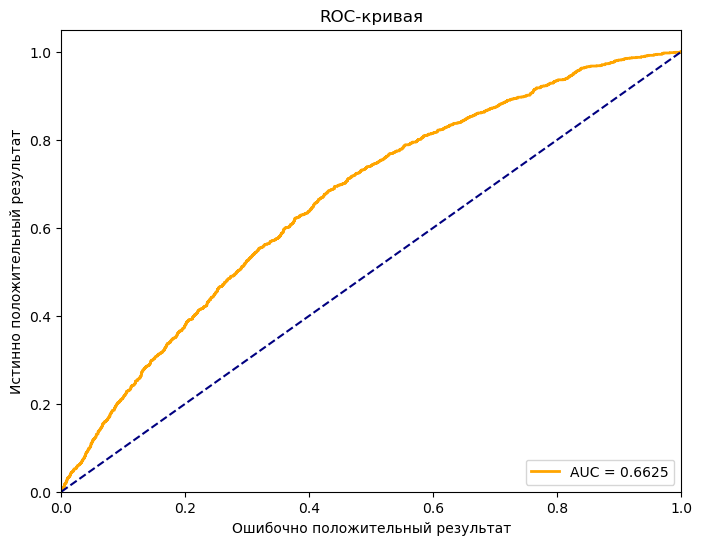

In [94]:
# Выводим оценку модели
print(f'AUC на тестовом наборе: {auc:.4f}')
print('Классификация:')
print(report)
plot_roc_curve(best_pipe, X_test, y_test)

In [95]:
# Сохраняем модель в формате pkl
model_file = './../models/LinearRegr.pkl'                   # Ноутбук
# model_file = './../../models/LinearRegr.pkl'                # Скрипт
dump(best_pipe, model_file)

['./../models/LinearRegr.pkl']

In [96]:
# Сохраняем модель и завершаем логирование
mlflow.sklearn.log_model(best_pipe, "model")
mlflow.end_run()

2025/10/31 19:59:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# Судя по отчету, можно сказать, что линейная регрессия не слишком подходит для выявления дефолта :(

In [97]:
# Сохраняем метрики в json-файл
metrics = {
    "accuracy": accuracy,
    "auc": auc,
    "f1": f1
}

metric_file = './../models/LinearRegr_metrics.json'                   # Ноутбук
# metric_file = './../../models/LinearRegr_metrics.json'                # Скрипт
with open(metric_file, "w") as f:
    json.dump(metrics, f)

In [98]:
model = mlflow.search_runs(filter_string="tags.mlflow.runName = 'pipeline'")
model

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_auc,metrics.test_f1,metrics.test_accuracy,params.classifier__C,params.classifier__solver,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name
0,5a232264c204462a84bbfcfe1053db88,0,FINISHED,file:///C:/Users/BMakunin/SF/mlops/MLOps/noteb...,2025-10-31 16:58:27.753000+00:00,2025-10-31 16:59:06.903000+00:00,0.662493,0.88,0.781167,10,liblinear,LOCAL,pipeline,"[{""run_id"": ""5a232264c204462a84bbfcfe1053db88""...",BMakunin,C:\ProgramData\anaconda3\envs\myenv\lib\site-p...
1,34ede241b9c848e4a77fe78f1906f184,0,FINISHED,file:///C:/Users/BMakunin/SF/mlops/MLOps/noteb...,2025-10-31 15:33:25.916000+00:00,2025-10-31 15:34:01.488000+00:00,0.662493,0.88,NaN,10,liblinear,LOCAL,pipeline,"[{""run_id"": ""34ede241b9c848e4a77fe78f1906f184""...",BMakunin,C:\ProgramData\anaconda3\envs\myenv\lib\site-p...
2,16d26b6f78344b86a6d8f15567a6f444,0,FINISHED,file:///C:/Users/BMakunin/SF/mlops/MLOps/noteb...,2025-10-31 15:05:18.090000+00:00,2025-10-31 15:14:19.393000+00:00,0.662493,0.88,NaN,10,liblinear,LOCAL,pipeline,"[{""run_id"": ""16d26b6f78344b86a6d8f15567a6f444""...",BMakunin,C:\ProgramData\anaconda3\envs\myenv\lib\site-p...
